In [2]:
# Cell 1: Download and preprocess CIFAR-10 and PCam datasets for ResNet34 (224x224)

import torch, gc
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from torchvision.utils import draw_bounding_boxes
# from pytorch_grad_cam import GradCAM
from pytorch_grad_cam import GradCAMPlusPlus as GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from captum.attr import IntegratedGradients, GradientShap , LayerGradCam  
import torch.nn.functional as F
import torch.nn as nn

import os, random
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report,precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr, kendalltau
# from skimage.metrics import structural_similarity as ssim
import torchvision.transforms.functional as TF
from sklearn.utils.class_weight import compute_class_weight

import pickle
import pandas as pd
from collections import Counter
from PIL import Image
import quantus
from quantus.metrics.complexity import Sparseness
from quantus.metrics.faithfulness import PixelFlipping
from quantus.metrics.robustness import Consistency
from pathlib import Path

from functools import partial
import copy


In [3]:
#For reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


In [1]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")
print(f"Using device: {device}")


Using device: cuda


Load the dataset with transformations

In [4]:
# ImageNet normalization stats for ResNet34 pretrained weights [6][9]

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]


# Cifar transform: resize to 224x224, convert to tensor, normalize
cifar_train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

cifar_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])



# CIFAR-10 download and preprocessing
cifar10_train = datasets.CIFAR10(
    root='./data',
    train=True,
    download=False,
    transform=cifar_train_transform
)
cifar10_test = datasets.CIFAR10(
    root='./data',
    train=False,
    download=False,
    transform=cifar_test_transform
)

# Example DataLoader setup (adjust batch_size as needed)
# cifar10_train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True,persistent_workers=True)
# cifar10_test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True,persistent_workers=True)


# print("CIFAR-10 and PCam datasets are downloaded and preprocessed to 224x224 for ResNet34.")


In [5]:
# For full dataset training, you can use the following DataLoader setup:
batch_size = 500
workers = 4
def create_stratified_subset(dataset, subset_length, seed=42):
    """
    Creates a stratified random subset of the dataset.
    """
    # Get all labels from the dataset (assumes dataset has targets/labels attribute)
    if hasattr(dataset, 'targets'):
        labels = np.array(dataset.targets)
    elif hasattr(dataset, 'labels'):
        labels = np.array(dataset.labels)
    else:
        raise AttributeError("Dataset must have 'targets' or 'labels' attribute for stratified sampling.")

    indices = np.arange(len(dataset))
    # Use train_test_split to get a stratified subset
    subset_indices, _ = train_test_split(
        indices,
        train_size=subset_length,
        stratify=labels,
        random_state=seed
    )
    return Subset(dataset, subset_indices)

cifar_train = create_stratified_subset(cifar10_train, 40000)
cifar_val = create_stratified_subset(cifar10_train, 10000)

cifar_train_loader = DataLoader(
    cifar_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers,
    pin_memory=True,
    persistent_workers=True
)

cifar_val_loader = DataLoader(
    cifar_val,
    batch_size=batch_size,
    shuffle=False,
    num_workers=workers,
    pin_memory=True,
    persistent_workers=True
)

cifar_test_loader = DataLoader(
    cifar10_test,
    batch_size=batch_size,
    shuffle=False,
    num_workers=workers,
    pin_memory=True,
    persistent_workers=True
)
print(f"CIFAR-10 Train subset size: {len(cifar_train)}")
print(f"CIFAR-10 Validation subset size: {len(cifar_val)}")
print(f"CIFAR-10 Test subset size: {len(cifar10_test)}")

CIFAR-10 Train subset size: 40000
CIFAR-10 Validation subset size: 10000
CIFAR-10 Test subset size: 10000


## Finding variablity in dataset

In [6]:
# For demonstration, collect first N samples
N = 2000
data_list, label_list = [], []
count = 0

for images, labels in cifar_train_loader:
    batch_size = images.size(0)
    images = images.view(batch_size, -1).cpu().numpy()  # flatten per image
    data_list.append(images)
    label_list.append(labels.cpu().numpy())
    count += batch_size
    if count >= N:  # break after collecting ~N images
        break

X = np.concatenate(data_list)[:N]
y = np.concatenate(label_list)[:N]


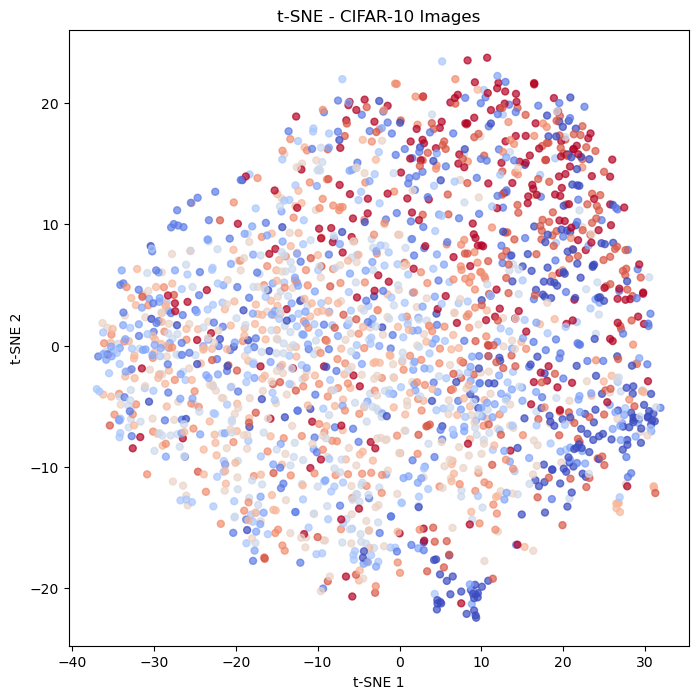

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X)

plt.figure(figsize=(8,8))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y, cmap='coolwarm', s=25, alpha=0.7)
# plt.colorbar()
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE - CIFAR-10 Images')
plt.show()


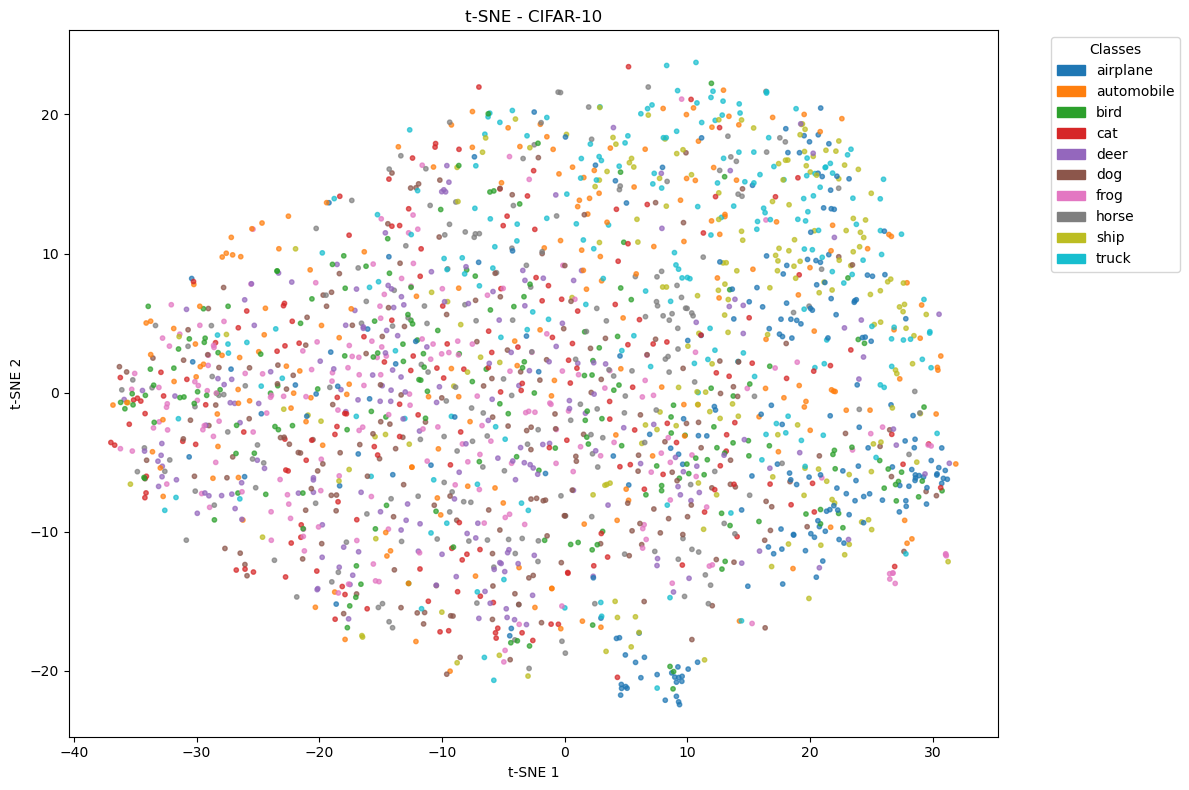

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(12,8))
scatter = plt.scatter(X_embedded[:,0], X_embedded[:,1], c=y, cmap='tab10', s=10, alpha=0.7)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE - CIFAR-10')

# Create legend
handles = []
colors = plt.cm.tab10.colors
for idx, class_name in enumerate(class_names):
    handles.append(mpatches.Patch(color=colors[idx], label=class_name))
plt.legend(handles=handles, title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [6]:
import numpy as np

# X: shape (num_samples, num_features)
# Example: X = np.concatenate(data_list) from your earlier code

# Variance across all samples for each feature (pixel or feature)
feature_variances = np.var(X, axis=0)

# Mean variance per feature (a simple global measure of variability)
mean_variability = np.mean(feature_variances)
print("Mean Variance (global variability):", mean_variability)

# Standard deviation
feature_stddevs = np.std(X, axis=0)
mean_stddev = np.mean(feature_stddevs)
print("Mean Standard Deviation (global variability):", mean_stddev)


Mean Variance (global variability): 1.1608295
Mean Standard Deviation (global variability): 1.0736506


In [11]:
sample_variances = np.var(X, axis=1)
print("Sample variances:", sample_variances)


Sample variances: [0.5409905 1.3405485 0.5930562 ... 1.0492153 0.9179917 0.6055221]


In [7]:
for label in np.unique(y):
    class_samples = X[y == label]
    class_variance = np.var(class_samples)
    print(f"Variance for class {label}: {class_variance}")


Variance for class 0: 1.269007682800293
Variance for class 1: 1.3627369403839111
Variance for class 2: 1.0073355436325073
Variance for class 3: 1.2368228435516357
Variance for class 4: 0.8412542343139648
Variance for class 5: 1.1455597877502441
Variance for class 6: 0.9200750589370728
Variance for class 7: 1.1244198083877563
Variance for class 8: 1.2156771421432495
Variance for class 9: 1.4028878211975098


Make the subsets from saved indices

In [5]:
batch_size = 500
workers = 4
print(f"Number of workers: {workers}")
# Load the balanced splits
# PCam
with open('./data/balanced_splits/pcam_train_idx.pkl', 'rb') as f:
    train_idx = pickle.load(f)
with open('./data/balanced_splits/pcam_val_idx.pkl', 'rb') as f:
    val_idx = pickle.load(f)
with open('./data/balanced_splits/pcam_test_idx.pkl', 'rb') as f:
    test_idx = pickle.load(f)
with open('./data/balanced_splits/pcam_tracking_idx.pkl', 'rb') as f:
    pcam_tracking_idx = pickle.load(f)

# CIFAR-10
with open('./data/balanced_splits/cifar_train_idx.pkl', 'rb') as f:
    cifar_train_idx = pickle.load(f)
with open('./data/balanced_splits/cifar_val_idx.pkl', 'rb') as f:
    cifar_val_idx = pickle.load(f)
with open('./data/balanced_splits/cifar_test_idx.pkl', 'rb') as f:
    cifar_test_idx = pickle.load(f)
with open('./data/balanced_splits/cifar_tracking_idx.pkl', 'rb') as f:
    cifar_tracking_idx = pickle.load(f)

def create_random_subset(dataset, subset_length, seed=42):
    """
    Quickly creates a random subset of the dataset.
    """
    np.random.seed(seed)
    indices = np.random.choice(len(dataset), subset_length, replace=False)
    return Subset(dataset, indices)


cifar_train_subset = Subset(cifar10_train, cifar_train_idx)
cifar_val_subset = Subset(cifar10_train, cifar_val_idx)
cifar_test_subset = Subset(cifar10_test, cifar_test_idx)
cifar_tracking_subset = Subset(cifar_val_subset, cifar_tracking_idx)

cifar_train_loader = DataLoader(
    cifar_train_subset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers,
    pin_memory=True,
    persistent_workers=True
)

cifar_val_loader = DataLoader(
    cifar_val_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=workers,
    pin_memory=True,
    persistent_workers=True
)

cifar_test_loader = DataLoader(
    cifar_test_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=workers,
    pin_memory=True,
    persistent_workers=True
)

print(f"CIFAR-10 Train subset size: {len(cifar_train_subset)}")
print(f"CIFAR-10 Validation subset size: {len(cifar_val_subset)}")
print(f"CIFAR-10 Test subset size: {len(cifar_test_subset)}")
print(f"CIFAR-10 Tracking subset size: {len(cifar_tracking_subset)}")


Number of workers: 4
CIFAR-10 Train subset size: 40000
CIFAR-10 Validation subset size: 10000
CIFAR-10 Test subset size: 10000
CIFAR-10 Tracking subset size: 100


In [6]:
# Initialize ResNet34 model for CIFAR-10 and PCam
def initialize_resnet34(num_classes, device=None):
    """
    Initializes a ResNet34 model with a specified number of output classes.

    Args:
        num_classes (int): Number of output classes for the classification task.
        device (torch.device, optional): The device to load the model onto. Defaults to CUDA if available.

    Returns:
        torch.nn.Module: The initialized ResNet34 model.
    """
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    
    print(f"Initialized ResNet34 for {num_classes} classes on {device} (DataParallel={torch.cuda.device_count() > 1})")
    return model.to(device)


# Initialize models for CIFAR-10 and PCam
cifar_model = initialize_resnet34(num_classes=10, device=device)


Initialized ResNet34 for 10 classes on cuda (DataParallel=False)


<h1>This is for XAI AL but for specific cases</h1>

In [7]:
import json
import time
import os

def save_training_metadata(
    cycle,
    dataset_name,
    model_architecture,
    num_classes,
    train_loader,
    hyperparameters,
    val_metrics,
    class_weights=None,
    save_dir='/home/jovyan/data/models/cifar/random_sampling'
):
    """
    Save training metadata as a JSON file alongside model checkpoints.

    Args:
        cycle (int): Active learning cycle number.
        dataset_name (str): Name of the dataset.
        model_architecture (str): Model architecture name.
        num_classes (int): Number of output classes.
        train_loader (DataLoader): Training data loader to get dataset size.
        hyperparameters (dict): Dictionary of training hyperparameters.
        val_metrics (dict): Dictionary of validation metrics (e.g., loss, recall).
        class_weights (torch.Tensor, optional): Class weights used in training.
        save_dir (str): Directory to save the metadata JSON file.

    Returns:
        None
    """
    metadata = {
        "cycle": cycle,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "dataset": dataset_name,
        "model_architecture": model_architecture,
        "num_classes": num_classes,
        "train_size": train_loader,
        "hyperparameters": hyperparameters,
        "class_weights": class_weights.tolist() if class_weights is not None else None,
        "val_metrics": val_metrics
    }

    # Ensure save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Save metadata as JSON
    metadata_path = os.path.join(save_dir, f"{cycle}_metadata.json")
    with open(metadata_path, "w") as f:
        json.dump(metadata, f, indent=2)

    print(f"Metadata saved to {metadata_path}")


CNN Training Code

In [8]:

# ================== TORCH WRAPPER WITH EARLY STOPPING ==================
class TorchWrapper:
    def __init__(self, model):
        self.model = model
        self.device = next(model.parameters()).device
        self.best_weights = None
        
    def fit(self, train_loader, val_loader=None, epochs=5, patience=3, dataset_name='cifar10', cycle =1, batch_size = 256, Labeled = 1):
        self.model.train()
        lr=1e-4
        weight_decay=1e-3
        scheduler_factor=0.1
        scheduler_patience=6
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=scheduler_factor, patience=scheduler_patience)
        criterion = torch.nn.CrossEntropyLoss()    
        best_val_loss = float('inf')
        best_train_loss = float('inf')
        best_val_recall = 0.0
        patience_counter = 0
        class_weights = None
    

        for epoch in range(epochs):
            # Training
            train_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # Validation and early stopping
                
            if val_loader:
                val_loss = 0.0
                self.model.eval()
                with torch.no_grad():
                    for val_images, val_labels in val_loader:
                        val_images = val_images.to(self.device)
                        val_labels = val_labels.to(self.device)
                        outputs = self.model(val_images)
                        val_loss += criterion(outputs, val_labels).item()

                avg_val_loss = val_loss / len(val_loader)
                avg_train_loss = train_loss / len(train_loader)
                scheduler.step(avg_val_loss)  # Update learning rate based on validation loss
                print(f"Epoch {epoch+1}: Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {avg_val_loss:.4f}")

                if avg_val_loss < best_val_loss:  # Early stopping based on validation loss
                    best_train_loss = avg_train_loss
                    best_val_loss = avg_val_loss
                    self.best_weights = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print("Early stopping triggered!")
                        self.model.load_state_dict(self.best_weights)
                        torch.save(self.model.state_dict(), f'/home/jovyan/data/models/cifar/random_sampling/{cycle}.pth')
                        print(f'saved model : /home/jovyan/data/models/cifar/random_sampling')
                        # Save metadata
                        save_training_metadata(
                            cycle=cycle,
                            dataset_name='cifar10',
                            model_architecture='ResNet34',
                            num_classes=10,
                            train_loader=Labeled,
                            hyperparameters={'learning_rate': lr, 'batch_size': batch_size, 'epochs': epoch+1, 'weight_decay': weight_decay, 'scheduler_factor': scheduler_factor, 'scheduler_patience': scheduler_patience},
                            val_metrics={'val_loss': best_val_loss},
                            class_weights=class_weights  # or None if not used 
                            )
                        torch.cuda.empty_cache()
                        torch.save(self.model.state_dict(), 'best_model.pth')
                        break


            torch.cuda.empty_cache()

    def predict_proba(self, data_loader):
        self.model.eval()
        probs = []
        with torch.no_grad():
            for images, _ in data_loader:
                images = images.to(self.device)
                outputs = self.model(images)
                probs.append(torch.softmax(outputs, dim=1).cpu())
        return torch.cat(probs).numpy()

In [ ]:
# Full dataset training 
# Uncomment the following lines to train on the full CIFAR-10 dataset
# model = cifar_model
# wrapper = TorchWrapper(model)
# wrapper.fit(train_loader = cifar_train_loader,  val_loader= cifar_val_loader, epochs=120, patience=10, batch_size=500) 

Epoch 1: Train Loss: 0.4213 | Val Loss: 0.1290
Epoch 2: Train Loss: 0.1687 | Val Loss: 0.0962
Epoch 3: Train Loss: 0.0934 | Val Loss: 0.0579
Epoch 4: Train Loss: 0.0655 | Val Loss: 0.0447
Epoch 5: Train Loss: 0.0550 | Val Loss: 0.0423
Epoch 6: Train Loss: 0.0376 | Val Loss: 0.0353
Epoch 7: Train Loss: 0.0375 | Val Loss: 0.0180
Epoch 8: Train Loss: 0.0276 | Val Loss: 0.0407
Epoch 9: Train Loss: 0.0282 | Val Loss: 0.0370
Epoch 10: Train Loss: 0.0230 | Val Loss: 0.0148
Epoch 11: Train Loss: 0.0263 | Val Loss: 0.0143
Epoch 12: Train Loss: 0.0167 | Val Loss: 0.0196
Epoch 13: Train Loss: 0.0178 | Val Loss: 0.0154
Epoch 14: Train Loss: 0.0128 | Val Loss: 0.0125
Epoch 15: Train Loss: 0.0153 | Val Loss: 0.0213
Epoch 16: Train Loss: 0.0149 | Val Loss: 0.0179
Epoch 17: Train Loss: 0.0181 | Val Loss: 0.0148
Epoch 18: Train Loss: 0.0132 | Val Loss: 0.0240
Epoch 19: Train Loss: 0.0190 | Val Loss: 0.0154
Epoch 20: Train Loss: 0.0157 | Val Loss: 0.0046
Epoch 21: Train Loss: 0.0144 | Val Loss: 0.0084
E

In [ ]:
# val_loader= cifar_val_loader
# dataset_name = "cifar"
# if val_loader:
#     val_acc, val_prec, val_rec, val_f1, val_auc = evaluate_model(model, val_loader, device, dataset_name)
#     print(f"Validation Accuracy: {val_acc:.3f} | Validation Prec: {val_prec:.3f} | Validation Recall: {val_rec:.3f} | val F1: {val_f1:.3f} | val AUC: {val_auc:.3f}")

Validation Accuracy: 1.000 | Validation Prec: 1.000 | Validation Recall: 1.000 | val F1: 1.000 | val AUC: 1.000


XAI Visaulization Functions

In [9]:
# ================== TRACKING DATASET LOADER ==================
def get_xai_loader(tracking_subset, n_samples=100):
    # Use only the first n_samples for testing
    indices = list(range(min(n_samples, len(tracking_subset))))
    test_subset = Subset(tracking_subset, indices)
    loader = DataLoader(test_subset, batch_size=len(indices), shuffle=False)
    images, labels = next(iter(loader))
    return images, labels, indices

# ================== VISUALIZATION UTILITIES ==================
def overlay_center_box(img, mean, std, box_size=75, color="lime", width=1):
    """
    img: torch tensor [C, H, W], normalized
    mean, std: lists or arrays of length 3 (for unnormalization)
    """
    # Unnormalize
    img_disp = img.clone()
    for c in range(3):
        img_disp[c] = img_disp[c] * std[c] + mean[c]
    img_disp = (img_disp * 255).clamp(0,255).to(torch.uint8)

    # Box coordinates for 96x96 image
    H, W = img_disp.shape[1:]
    xmin = (W - box_size) // 2
    ymin = (H - box_size) // 2
    xmax = xmin + box_size
    ymax = ymin + box_size
    boxes = torch.tensor([[xmin, ymin, xmax, ymax]], dtype=torch.int)

    # Draw box
    boxed_img = draw_bounding_boxes(img_disp, boxes, colors=color, width=width)
    return boxed_img.permute(1,2,0).cpu().numpy() / 255.0  # For plt.imshow

# ================== RESIZE FOR VISUALIZATION ==================
def resize_for_visualization(img_tensor, size=None):
    """
    img_tensor: torch.Tensor of shape [C, H, W]
    size: tuple (height, width)
    Returns resized tensor of shape [C, size[0], size[1]]
    """
    # Add batch dimension
    img_batch = img_tensor.unsqueeze(0)  # [1, C, H, W]

    # Resize using bilinear interpolation (good quality for images)
    resized_batch = F.interpolate(img_batch, size=size, mode='bilinear', align_corners=False)

    # Remove batch dimension
    resized_img = resized_batch.squeeze(0)  # [C, size[0], size[1]]

    return resized_img

# ================== UNNORMALIZE FUNCTION ==================
def unnormalize(img, mean, std):
    # Handle PyTorch tensors without converting to numpy
    if isinstance(img, torch.Tensor):
        img = img.clone()
        for c in range(img.shape[0]):
            img[c] = img[c] * std[c] + mean[c]
        return img  # Keep as tensor
    # Handle numpy arrays
    else:
        if img.ndim == 2:
            img = np.expand_dims(img, axis=0)
        img = img.transpose(1, 2, 0)
        img = img * std + mean
        return np.clip(img, 0, 1)


def normalize(img, mean, std):
    # img: [H, W, C] numpy array, values in [0, 1]
    img = (img - mean) / std
    img = img.transpose(2, 0, 1)  # [C, H, W]
    return img

def normalize_cifar(img,mean = IMAGENET_MEAN, std = IMAGENET_STD):
    """Normalize CIFAR-10 image in [C, H, W] format."""
    # Reshape mean/std to [3, 1, 1] for channel-wise operations
    mean = np.array(mean).reshape(3, 1, 1)
    std = np.array(std).reshape(3, 1, 1)
    return (img - mean) / std

def unnormalize_cifar(img, mean = IMAGENET_MEAN, std = IMAGENET_STD):
    """Unnormalize CIFAR-10 image in [C, H, W] format."""
    mean = np.array(mean).reshape(3, 1, 1)
    std = np.array(std).reshape(3, 1, 1)
    return np.clip(img * std + mean, 0, 1)


# ================== XAI VISUALIZATION ==================
def show_xai(images, labels, model, gradshap, gradcam, device, idxs, mean, std, dataset_name = None,
             class_names=[], baseline_loader=None, n_baselines=10, overlay_box=False, baseline_imgs=None, cycle=0):
    
    save_dir = f"data/xai_images/{dataset_name}/two/cycle_{cycle}"
    os.makedirs(save_dir, exist_ok=True)

    # Handle DataParallel models
    if isinstance(model, torch.nn.DataParallel):
        model_for_gc = model.module
    else:
        model_for_gc = model
        
    model.eval()
    images = images.to(device)
    labels = labels.to(device)

    # Get baselines
    if baseline_imgs is not None:
        baseline_imgs = baseline_imgs
    elif baseline_loader is not None:
        baseline_imgs = []
        for b_images, _ in baseline_loader:
            baseline_imgs.append(b_images.to(device))
            if len(baseline_imgs) >= n_baselines:
                break
        baseline_imgs = torch.cat(baseline_imgs)[:n_baselines]
    else:
        baseline_imgs = torch.randn(n_baselines, *images.shape[1:], device=device)

    # Compute explanations
    with torch.no_grad():
        outputs = model(images)
        preds = outputs.argmax(1).cpu().numpy()
    
    # GradientShap
    attr_gs = gradshap.attribute(images, baselines=baseline_imgs, target=labels).cpu().numpy()
    
    # GradCAM++
    gradcam_output = gradcam(input_tensor=images,
                            targets=[ClassifierOutputTarget(l.item()) for l in labels],
                            aug_smooth=True)
    
    # Visualization
    for i in range(images.shape[0]):
        img = images[i].cpu()
        if dataset_name == "pcam":
        # Resize to 96x96 for visualization
            res_img = resize_for_visualization(img, size=(96, 96))
        else:
            res_img = resize_for_visualization(img, size=(32, 32))
        
        if overlay_box:
            img_disp = overlay_center_box(img, mean, std)      
        else:
            img_disp = unnormalize_cifar(img, mean, std)    
            img_disp = np.transpose(img_disp, (1, 2, 0))  # shape: (H, W, 3)



        fig = plt.figure(figsize=(12, 3))
        
        # Original image
        plt.subplot(1,3,1)
        plt.imshow(img_disp)
        plt.title(f"ID {idxs[i]}\nTrue: {class_names[labels[i].item()]}\nPred: {class_names[preds[i]]}")
        plt.axis('off')

        # GradientShap
        plt.subplot(1,3,2)
        gs_map = np.abs(attr_gs[i]).sum(0)
        gs_map = (gs_map - gs_map.min()) / (gs_map.max() - gs_map.min() + 1e-8)
        plt.imshow(img_disp)
        plt.imshow(gs_map, cmap='hot', alpha=0.5)
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.title("GradientSHAP \n (higher = more important)")
        plt.axis('off')

        # GradCAM++
        plt.subplot(1,3,3)
        gc_map = gradcam_output[i]
        gc_map = (gc_map - gc_map.min()) / (gc_map.max() - gc_map.min() + 1e-8)
        plt.imshow(img_disp)
        plt.imshow(gc_map, cmap='jet', alpha=0.5)
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.title("GradCAM++" "\n (higher = more important)")
        plt.axis('off')

        # Save instead of showing
        output_path = os.path.join(save_dir, f"xai_{idxs[i]}.png")
        plt.tight_layout()
        plt.savefig(output_path, bbox_inches='tight')
        plt.close(fig)  # Prevent memory leaks

    print(f"Saved {images.shape[0]} XAI visualizations to {save_dir}")
    gc.collect()
    torch.cuda.empty_cache()


Model evaluation for VAL dataset

In [10]:
# ================== EVALUATION FUNCTION ==================
def evaluate_model(model, data_loader, device, dataset_name):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)  # Get class probabilities
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    if dataset_name == "pcam":
        # Binary classification (e.g., PCam)
        auc = roc_auc_score(all_labels, all_probs[:, 1])
        return (
            accuracy_score(all_labels, all_preds),
            precision_score(all_labels, all_preds, zero_division=0),
            recall_score(all_labels, all_preds, zero_division=0),
            f1_score(all_labels, all_preds, zero_division=0),
            auc 
        )
    else:
        # Multiclass classification (e.g., CIFAR-10)
        auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
        return (
            accuracy_score(all_labels, all_preds),
            precision_score(all_labels, all_preds, average='macro', zero_division=0),
            recall_score(all_labels, all_preds, average='macro', zero_division=0),
            f1_score(all_labels, all_preds, average='macro', zero_division=0),
            auc
        )


CIFAR-10 SPecific functions 

In [11]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
def normalize_cifar(img,mean = IMAGENET_MEAN, std = IMAGENET_STD):
    """Normalize CIFAR-10 image in [C, H, W] format."""
    # Reshape mean/std to [3, 1, 1] for channel-wise operations
    mean = np.array(mean).reshape(3, 1, 1)
    std = np.array(std).reshape(3, 1, 1)
    return (img - mean) / std

def unnormalize_cifar(img, mean = IMAGENET_MEAN, std = IMAGENET_STD):
    """Unnormalize CIFAR-10 image in [C, H, W] format."""
    mean = np.array(mean).reshape(3, 1, 1)
    std = np.array(std).reshape(3, 1, 1)
    return np.clip(img * std + mean, 0, 1)


def rotation_perturbation(arr, mean,degree, std, **kwargs):
    """Handles CIFAR-10 images in [C, H, W] format."""
    # 1. Unnormalize to [0,1] range
    img_unnorm = unnormalize_cifar(arr, mean, std)  # [C, H, W]
    
    # 2. Convert to PIL format (needs [H, W, C])
    img_pil = Image.fromarray(
        (img_unnorm.transpose(1, 2, 0) * 255).astype(np.uint8)
    )
    
    # 3. Apply rotation
    img_pil = img_pil.rotate(degree)  # 15° rotation for natural images
    
    # 4. Convert back to [C, H, W]
    img_rot = np.array(img_pil).astype(np.float32) / 255.0
    img_rot = img_rot.transpose(2, 0, 1)  # [H, W, C] → [C, H, W]
    
    # 5. Re-normalize
    return normalize_cifar(img_rot, mean, std)

# ================== MODIFIED XAI FUNCTIONS ==================
def gradcam_callable(model, inputs, targets, gradcam, cycle=None, sample_indices=None, dataset_name=None):
    """Computes GradCAM maps and saves them."""
    attributions = []
    for i, (img, label) in enumerate(zip(inputs, targets)):
        img_tensor = torch.from_numpy(img).to(device)
        attr = gradcam(input_tensor=img_tensor.unsqueeze(0), 
                      targets=[ClassifierOutputTarget(label)])[0]
        
        # Process attribution
        if attr.ndim == 3:
            attr = attr.squeeze(0)
        attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)
        
        # # Save if tracking
        # if cycle is not None and sample_indices is not None:
        #     save_xai_map(attr, cycle, sample_indices[i], "gradcam", dataset_name, cmap='jet')
        #     save_overlay(unnormalize_cifar(img), attr, cycle, sample_indices[i], "gradcam", dataset_name, cmap='jet')
            
        attributions.append(attr)
    return np.stack(attributions)

def shap_callable(model, inputs, targets, gradshap, baseline_imgs, cycle=None, sample_indices=None, dataset_name=None):
    """Computes SHAP maps and saves them."""
    attributions = []
    for i, (img, label) in enumerate(zip(inputs, targets)):
        img_tensor = torch.from_numpy(img).to(device)
        attr = gradshap.attribute(img_tensor.unsqueeze(0), 
                                    baselines=baseline_imgs,
                                    target=label,
                                    n_samples=200  # Increase from default (50-100)
                                 )
            
            # Process attribution
        attr = attr.cpu().numpy()
        attr = np.abs(attr).sum(axis=1).squeeze()  # [H, W]
        attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)
        # # Save if tracking
        # if cycle is not None and sample_indices is not None:
        #     save_xai_map(attr, cycle, sample_indices[i], "shap", dataset_name, cmap='hot')
        #     save_overlay(unnormalize_cifar(img), attr, cycle, sample_indices[i], "shap", dataset_name, cmap='hot')

            
        attributions.append(attr)
    return np.stack(attributions)

In [12]:
def gradcam_callable(model, inputs, targets, gradcam, cycle=None, sample_indices=None, dataset_name=None):
    """Computes GradCAM maps and saves them."""
    attributions = []
    device = next(model.parameters()).device

    for i, (img, label) in enumerate(zip(inputs, targets)):
        # Handle both tensor and numpy input types
        if isinstance(img, torch.Tensor):
            img_tensor = img.to(device)
        else:
            img_tensor = torch.from_numpy(img).to(device)
        
        # Handle both tensor and numpy label types
        if isinstance(label, torch.Tensor):
            label = label.item()
        else:
            label = int(label)
            
        attr = gradcam(input_tensor=img_tensor.unsqueeze(0), 
                      targets=[ClassifierOutputTarget(label)])[0]
        
        # Process attribution
        if attr.ndim == 3:
            attr = attr.squeeze(0)
        attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)
        attributions.append(attr)
    return np.stack(attributions)

def shap_callable(model, inputs, targets, gradshap, baseline_imgs, cycle=None, sample_indices=None, dataset_name=None):
    """Computes SHAP maps and saves them."""
    attributions = []
    device = next(model.parameters()).device

    # Ensure baseline_imgs is on correct device
    baseline_imgs = baseline_imgs.to(device)
    
    for i, (img, label) in enumerate(zip(inputs, targets)):
        # Handle both tensor and numpy input types
        if isinstance(img, torch.Tensor):
            img_tensor = img.to(device)
        else:
            img_tensor = torch.from_numpy(img).to(device)
        
        # Handle both tensor and numpy label types
        if isinstance(label, torch.Tensor):
            label = label.item()
        else:
            label = int(label)
            
        attr = gradshap.attribute(img_tensor.unsqueeze(0), 
                                  baselines=baseline_imgs,
                                  target=label,
                                  n_samples=200)
            
        # Process attribution
        attr = attr.cpu().numpy()
        attr = np.abs(attr).sum(axis=1).squeeze()
        attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)
        attributions.append(attr)
    return np.stack(attributions)


In [13]:
def continuity_gradcam( model, x_batch, y_batch,correlation, gradcam_explain_func, perturb_func, perturb_kwargs):
    if correlation == "pearson":
        corr_function = quantus.correlation_pearson
    elif correlation == "spearman":
        corr_function = quantus.correlation_spearman
    elif correlation == "kendall":
        corr_function = quantus.correlation_kendall_tau
        
    continuity_scores_gradcam = quantus.LocalLipschitzEstimate(
            nr_samples=15,  # Number of perturbations per image
            perturb_func=perturb_func,
            similarity_func= corr_function,
            norm_numerator=lambda a: np.abs(a),  # Custom scalar normalization
            norm_denominator=lambda a: 1.0,      # Avoid division by zero
            normalise=False,
            abs=True,
            perturb_func_kwargs=perturb_kwargs
        )(
            model=model,
            x_batch=x_batch,
            y_batch=y_batch,
            explain_func=gradcam_explain_func
        )
    return continuity_scores_gradcam

def continuity_shap( model, x_batch, y_batch,correlation, shap_explain_func, perturb_func, perturb_kwargs):
    if correlation == "pearson":
        corr_function = quantus.correlation_pearson
    elif correlation == "spearman":
        corr_function = quantus.correlation_spearman
    elif correlation == "kendall":
        corr_function = quantus.correlation_kendall_tau
        
    continuity_scores_shap = quantus.LocalLipschitzEstimate(
            nr_samples=15,
            perturb_func=perturb_func,
            similarity_func=corr_function,
            norm_numerator=lambda a: np.abs(a),  # Custom scalar normalization
            norm_denominator=lambda a: 1.0,      # Avoid division by zero
            normalise=False,
            abs=True,
            perturb_func_kwargs=perturb_kwargs
        )(
            model=model,
            x_batch=x_batch,
            y_batch=y_batch,
            explain_func=shap_explain_func
        )
    return continuity_scores_shap

def compute_consistency(explanations_history, correlation="spearman"):
    if correlation == "pearson":
        corr_function = pearsonr
    elif correlation == "spearman":
        corr_function = spearmanr
    elif correlation == "kendall":
        corr_function = kendalltau
    """Improved consistency with Spearman and pairwise comparison."""
    per_image_scores = {}
    for img_idx, attributions in explanations_history.items():
        if len(attributions) < 2:
            per_image_scores[img_idx] = 0.01
            continue
            
        # Compare all pairs, not just consecutive
        correlations = []
        for i in range(len(attributions)):
            for j in range(i+1, len(attributions)):
                attr1 = attributions[i].flatten()
                attr2 = attributions[j].flatten()
                
                # Use Spearman (rank correlation) for robustness
                corr, _ = corr_function(attr1, attr2)
                
                if not np.isnan(corr):
                    correlations.append(abs(corr))
                    
        # Use median instead of mean to reduce outlier impact
        if correlations:
            per_image_scores[img_idx] = np.median(correlations)
        else:
            per_image_scores[img_idx] = 0.01
    return per_image_scores


In [14]:
def save_overlay(img, attr_map, cycle, sample_idx, method, dataset_name, cmap, alpha=0.4, suffix=""):
    save_dir = f"data/xai_maps/{dataset_name}/cycle_{cycle}"
    os.makedirs(save_dir, exist_ok=True)
    img_uint8 = (img.transpose(1, 2, 0) * 255).astype(np.uint8)
    plt.figure(figsize=(3,3))
    plt.imshow(img_uint8)
    plt.imshow(attr_map, cmap=cmap, alpha=alpha)
    plt.axis('off')
    plt.savefig(f"{save_dir}/{method}_overlay_{suffix}{sample_idx}.png", bbox_inches='tight', pad_inches=0)
    plt.close()



# ================== SAVING FUNCTIONS ==================
def save_perturbed_image(img, cycle, sample_idx, method, dataset_name):
    """Save original/perturbed images as PNG."""
    save_dir = f"data/perturbed_images/{dataset_name}/cycle_{cycle}"
    os.makedirs(save_dir, exist_ok=True)
    
    # Convert from [C, H, W] to [H, W, C] and scale to 0-255
    img = (img.transpose(1, 2, 0) * 255).astype(np.uint8)
    Image.fromarray(img).save(f"{save_dir}/{method}_sample_{sample_idx}.png")

def save_xai_map(attr_map, cycle, sample_idx, method, dataset_name, cmap):
    """Save XAI maps as PNG and NPY."""
    save_dir = f"data/xai_maps/{dataset_name}/cycle_{cycle}"
    os.makedirs(save_dir, exist_ok=True)
    
    # Save heatmap visualization
    plt.imsave(f"{save_dir}/{method}_heatmap_{sample_idx}.png", attr_map, cmap=cmap, alpha=0.3)
    # Save raw attribution values
    np.save(f"{save_dir}/{method}_raw_{sample_idx}.npy", attr_map)

#



CIFAR Active Learning Loop

In [15]:
def xal_with_visuals(dataset, model, mean, std, init_size=100, query_size=50, 
                    n_cycles=5, batch_size=512, workers=8, xai_image_size=2,
                    test_loader=None, val_loader=None, threshold=0.85, dataset_name="cifar10", tracking_subset=None):
    
    device = next(model.parameters()).device
    wrapper = TorchWrapper(model)
    dataset_name = dataset_name



    # Initial pool setup
    # Load your CIFAR-10 labels
    all_labels = np.load('./data/models/cifar_all_labels.npy')

    # Create all indices
    all_indices = np.arange(len(all_labels))

    
    # Stratified split for initial labeled and unlabeled indices
    labeled_indices, unlabeled_indices = train_test_split(
        all_indices,
        train_size=init_size,
        stratify=all_labels,
        random_state=42
    )

    # Check class distribution in your initial labeled set
    labeled_labels = all_labels[labeled_indices]
    unique, counts = np.unique(labeled_labels, return_counts=True)
    print("Initial labeled set class distribution:")
    for cls, count in zip(unique, counts):
        print(f"Class {cls}: {count} samples ({count/len(labeled_labels)*100:.2f}%)")

    distributions = []
    eval_metrics = []
    cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

    for cycle in range(n_cycles):
        print(f"\nAL Cycle {cycle+1}/{n_cycles} | Labeled: {len(labeled_indices)}")
        
        labeled_labels = all_labels[labeled_indices]
        unique, counts = np.unique(labeled_labels, return_counts=True)
        dist_dict = {
            'cycle': cycle,
            'labeled_samples': len(labeled_indices)
        }
        for cls_idx, count in zip(unique, counts):
            class_name = cifar10_classes[cls_idx]
            dist_dict[class_name] = count
        # Ensure all classes are present, fill with 0 if missing
        for class_name in cifar10_classes:
            if class_name not in dist_dict:
                dist_dict[class_name] = 0
        distributions.append(dist_dict)


        
        # Training
        train_loader = DataLoader(Subset(dataset, labeled_indices), 
                                batch_size=batch_size, shuffle=True,
                                num_workers=workers, pin_memory=True,
                                persistent_workers=False)
        
        if cycle < 5:
            wrapper.fit(train_loader, val_loader=val_loader, epochs=30, patience=5, dataset_name=dataset_name, cycle=cycle, batch_size=batch_size, Labeled = len(labeled_indices))
        else:
            wrapper.fit(train_loader, val_loader=val_loader, epochs=20, patience=5, dataset_name=dataset_name, cycle=cycle, batch_size=batch_size, Labeled = len(labeled_indices))

        # Validation check
        if val_loader:
            val_acc, val_prec, val_rec, val_f1, val_auc = evaluate_model(model, val_loader, device, dataset_name)
            print(f"Validation Accuracy: {val_acc:.3f} | Validation Prec: {val_prec:.3f} | Validation Recall: {val_rec:.3f} | val F1: {val_f1:.3f} | val AUC: {val_auc:.3f}")
        eval_metrics.append({
            "Cycle": cycle + 1,
            "Accuracy": val_acc,
            "Precision": val_prec,
            "Recall": val_rec,
            "F1": val_f1,
        })
        pd.DataFrame(eval_metrics).to_csv(Path('/home/jovyan/data/models/cifar/random_sampling/eval_metrics.csv'), index=False)
        print(f"Eval metrics saved to {Path('/home/jovyan/data/models/cifar/random_sampling/eval_metrics.csv')}")
        

        if cycle != n_cycles - 1:


            # Entropy based sampling
            # unlabeled_loader = DataLoader(Subset(dataset, unlabeled_indices),
            #                             batch_size=batch_size, shuffle=False,
            #                             num_workers=workers, pin_memory=True,
            #                             persistent_workers=False)
            # probs = wrapper.predict_proba(unlabeled_loader)
            # entropy = -np.sum(probs * np.log(probs + 1e-8), axis=1)
            # query_idx = np.argsort(-entropy)[:query_size]
            # labeled_indices = np.concatenate([labeled_indices, unlabeled_indices[query_idx]])
            # unlabeled_indices = np.delete(unlabeled_indices, query_idx)

            #Random sampling
            # Randomly choose query_size indices from the pool of unlabeled samples
            query_idx = np.random.choice(len(unlabeled_indices), size=query_size, replace=False)

            # Add the selected indices to labeled, and remove from unlabeled
            labeled_indices = np.concatenate([labeled_indices, unlabeled_indices[query_idx]])
            unlabeled_indices = np.delete(unlabeled_indices, query_idx)
            print(f"Selected {len(query_idx)} samples for labeling in cycle {cycle + 1}")

        if len(unlabeled_indices) == 0:
            print("★ Unlabeled pool exhausted ★")
            break
        
        save_dir=Path('/home/jovyan/data/models/cifar/random_sampling')
        df_class_distribution = pd.DataFrame(distributions)
        df_class_distribution.to_csv(save_dir/'class_distribution_evolution.csv', index=False)

        # Clear memory
        gc.collect()
        torch.cuda.empty_cache()

    return model


In [16]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
# Run active learning
final_model_cifar = xal_with_visuals(
    dataset=cifar_train_subset,
    model=cifar_model,
    mean=IMAGENET_MEAN,
    std=IMAGENET_STD,
    init_size=2000,
    query_size=100,
    n_cycles=20,
    batch_size=256,
    workers=4,
    val_loader=cifar_val_loader,
    test_loader=cifar_test_loader,
    threshold=0.9,
    dataset_name="cifar10",
    xai_image_size=100,
    tracking_subset=cifar_tracking_subset
)


Initial labeled set class distribution:
Class 0: 200 samples (10.00%)
Class 1: 200 samples (10.00%)
Class 2: 200 samples (10.00%)
Class 3: 200 samples (10.00%)
Class 4: 200 samples (10.00%)
Class 5: 200 samples (10.00%)
Class 6: 200 samples (10.00%)
Class 7: 200 samples (10.00%)
Class 8: 200 samples (10.00%)
Class 9: 200 samples (10.00%)

AL Cycle 1/20 | Labeled: 2000
Epoch 1: Train Loss: 1.7415 | Val Loss: 1.0943
Epoch 2: Train Loss: 0.5906 | Val Loss: 0.4847
Epoch 3: Train Loss: 0.2632 | Val Loss: 0.4656
Epoch 4: Train Loss: 0.1332 | Val Loss: 0.3754
Epoch 5: Train Loss: 0.0992 | Val Loss: 0.3508
Epoch 6: Train Loss: 0.0575 | Val Loss: 0.3888
Epoch 7: Train Loss: 0.0407 | Val Loss: 0.4321
Epoch 8: Train Loss: 0.0447 | Val Loss: 0.3869
Epoch 9: Train Loss: 0.0392 | Val Loss: 0.4291
Epoch 10: Train Loss: 0.0211 | Val Loss: 0.4494
Early stopping triggered!
saved model : /home/jovyan/data/models/cifar/random_sampling
Metadata saved to /home/jovyan/data/models/cifar/random_sampling/0_meta

In [13]:
# Custom model wrapper
class DeviceAwareModel(torch.nn.Module):
    def __init__(self, model, device):
        super().__init__()
        self.model = model
        self.device = device
        
    def forward(self, x, **kwargs):
        if isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.float32).to(self.device)
        elif isinstance(x, torch.Tensor) and x.device != self.device:
            x = x.to(self.device)
        return self.model(x, **kwargs)

def append_df_to_csv(df, filepath):
    file_exists = os.path.isfile(filepath)
    df.to_csv(filepath, mode='a', header=not file_exists, index=False)

In [14]:
n_cycles = 20
val_loader=cifar_val_loader
dataset_name="cifar10"
xai_image_size=100
tracking_subset=cifar_tracking_subset
mean=IMAGENET_MEAN
std=IMAGENET_STD

model_dir = '/home/jovyan/data/models/cifar/two/'

# Fixed XAI watchlist
xai_images, xai_labels, fixed_xai_indices = get_xai_loader(tracking_subset, n_samples=xai_image_size)
x_batch = xai_images.cpu().numpy()
y_batch = [int(label) for label in xai_labels.cpu().numpy()]  

# After loading xai_images and xai_labels
n_baselines = 50  # Number of baseline images

# Suppose tracked_indices is your list of tracked image indices (e.g., fixed_xai_indices)
explanations_history_gradcam = {img_idx: [] for img_idx in fixed_xai_indices}
explanations_history_shap = {img_idx: [] for img_idx in fixed_xai_indices}

# Preferred: Use real images from the validation set as baselines
if val_loader is not None:
    baseline_imgs = []
    for b_images, _ in val_loader:
        # b_images shape: [batch_size, 3, 32, 32]
        baseline_imgs.append(b_images)
        if sum(batch.shape[0] for batch in baseline_imgs) >= n_baselines:
            break
    baseline_imgs = torch.cat(baseline_imgs, dim=0)[:n_baselines].to(device)
else:
    # Fallback: Use random noise as baselines (less interpretable)
    baseline_imgs = torch.randn(n_baselines, 3, 32, 32, device=device)



for cycle in range(n_cycles):
    print(f"started: {cycle}")
    # Load weights into the existing model
    model=cifar_model
    aggregate_table_shap = []
    aggregate_table_gradcam = []
    per_image_table_shap = []
    per_image_table_gradcam = []
    device = next(model.parameters()).device


    checkpoint_path = f"{model_dir}{cycle}.pth"
    print(checkpoint_path)
    model.load_state_dict(torch.load(checkpoint_path))
    model.to(device)
    
    if val_loader:
        val_acc, val_prec, val_rec, val_f1, val_auc = evaluate_model(model, val_loader, device, dataset_name)
        print(f"Validation Accuracy: {val_acc:.3f} | Validation Prec: {val_prec:.3f} | Validation Recall: {val_rec:.3f} | val F1: {val_f1:.3f} | val AUC: {val_auc:.3f}")
        torch.cuda.empty_cache()

    # XAI visualization
    # Initialize GradCAM++
    model_for_gc = model.module if isinstance(model, torch.nn.DataParallel) else model
    gradcam = GradCAM(
        model=model_for_gc,
        target_layers=[model_for_gc.layer4[-1]]
    )

    gradshap = GradientShap(model)

    # show_xai(xai_images, xai_labels, model, gradshap, gradcam, device, 
    #         fixed_xai_indices, np.array(mean), np.array(std),dataset_name = dataset_name,
    #         class_names=[
    #             "airplane", "automobile", "bird", "cat", "deer",
    #             "dog", "frog", "horse", "ship", "truck"
    #         ], overlay_box=False,n_baselines=n_baselines,baseline_imgs=baseline_imgs, cycle=cycle

    #     )

    # XAI visualization
    # Must be 3-element lists for RGB

    assert len(mean) == 3, f"Expected 3 channels, got {len(mean)}"
    assert len(std) == 3, f"Expected 3 channels, got {len(std)}"

    perturb_func = partial(rotation_perturbation, mean=mean, std=std,cycle=cycle+1,degree=10,sample_idx=fixed_xai_indices,  dataset_name=dataset_name)
    perturb_kwargs = {} 
    gradcam_explain_func = partial(gradcam_callable, gradcam=gradcam, cycle=cycle+1, dataset_name=dataset_name, sample_indices=fixed_xai_indices)
    shap_explain_func = partial(shap_callable, gradshap=gradshap, baseline_imgs=baseline_imgs, cycle=cycle+1, dataset_name=dataset_name, sample_indices=fixed_xai_indices)
 
    # Assume device is set as in your model initialization
    # x_batch = xai_images.to(device)
    # y_batch = xai_labels.to(device)


    # CONTINUITY METRICS      
    # GradCAM continuity
    continuity_scores_gradcam = continuity_gradcam(
        model=model,
        x_batch=x_batch,
        y_batch=y_batch,
        correlation ="spearman",
        gradcam_explain_func=gradcam_explain_func,
        perturb_func=perturb_func,
        perturb_kwargs=perturb_kwargs
    )
    mean_continuity_gradcam = np.mean(continuity_scores_gradcam)
    median_continuity_gradcam = np.median(continuity_scores_gradcam)

    # SHAP continuity
    continuity_scores_shap = continuity_shap(
        model=model,
        x_batch=x_batch,
        y_batch=y_batch,
        correlation ="spearman",
        shap_explain_func=shap_explain_func,
        perturb_func=perturb_func,
        perturb_kwargs=perturb_kwargs
    )
    mean_continuity_shap = np.mean(continuity_scores_shap)
    median_continuity_shap = np.median(continuity_scores_shap)

    print("continuity done")

    #COMPACTNESS METRICS
    compactness_metric = Sparseness()

    # GradCAM compactness
    compactness_scores_gradcam = compactness_metric(
        model=model,
        x_batch=x_batch,
        y_batch=y_batch,
        explain_func=gradcam_explain_func
    )
    mean_compactness_gradcam = np.mean(compactness_scores_gradcam) 
    median_compactness_gradcam = np.median(compactness_scores_gradcam) 

    # SHAP compactness
    compactness_scores_shap = compactness_metric(
        model=model,
        x_batch=x_batch,
        y_batch=y_batch,
        explain_func=shap_explain_func
    )
    mean_compactness_shap = np.mean(compactness_scores_shap)
    median_compactness_shap = np.median(compactness_scores_shap)

    print("compactness done")
    torch.cuda.empty_cache()

    wrapped_model = DeviceAwareModel(model, next(model.parameters()).device)
    wrapped_model.eval()
    # CORRECTNESS METRICS
    # Instantiate the PixelFlipping metric
    correctness_metric = PixelFlipping(
        perturb_baseline="black",    # Mask important pixels with black (zero)
        features_in_step=112,         # Number of pixels/features to mask per step (adjust as needed) 2,4,8,16,32,64,112,224
        normalise=True,    disable_warnings=True
              # Normalize attributions before ranking
    )

    # Compute correctness scores for GradCAM
    correctness_scores_gradcam = correctness_metric(
        model=wrapped_model,
        x_batch=x_batch,
        y_batch=y_batch,
        explain_func=gradcam_explain_func
    )
    # Normalize by number of steps (max possible AUC = len(curve) - 1)
    normalized_auc_gradcam = [
        1-(np.trapz(curve) / (len(curve) - 1))  # Steps = len(curve) - 1
        for curve in correctness_scores_gradcam
    ]
    mean_correctness_gradcam = np.mean(normalized_auc_gradcam)
    median_correctness_gradcam = np.median(normalized_auc_gradcam)

    # Compute correctness scores for SHAP
    correctness_scores_shap = correctness_metric(
        model=wrapped_model,
        x_batch=x_batch,
        y_batch=y_batch,
        explain_func=shap_explain_func
    )
    normalized_auc_shap = [
        1-(np.trapz(curve) / (len(curve) - 1))
        for curve in correctness_scores_shap
    ]
    mean_correctness_shap = np.mean(normalized_auc_shap)
    median_correctness_shap = np.median(normalized_auc_shap)

    print("correctness done")


    # Consistency METRICS
    # Assuming x_batch, y_batch, fixed_xai_indices are defined for your tracked samples

    # GradCAM
    gradcam_attributions = gradcam_explain_func(model=model, inputs=x_batch, targets=y_batch, gradcam=gradcam)
    for i, img_idx in enumerate(fixed_xai_indices):
        attr = gradcam_attributions[i]
        attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)  # Normalize
        explanations_history_gradcam[img_idx].append(attr.flatten())

    # SHAP
    shap_attributions = shap_explain_func(model=model, inputs=x_batch, targets=y_batch, gradshap=gradshap, baseline_imgs=baseline_imgs)
    for i, img_idx in enumerate(fixed_xai_indices):
        attr = shap_attributions[i]
        attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)
        explanations_history_shap[img_idx].append(attr.flatten())

                # Get per-image consistency scores (dictionary: img_idx -> score)
    consistency_scores_gradcam = compute_consistency(explanations_history_gradcam)
    consistency_scores_shap = compute_consistency(explanations_history_shap)

    # Compute mean consistency (ignoring None or np.nan values)
    mean_consistency_gradcam = np.mean([v for v in consistency_scores_gradcam.values() if v is not None])
    median_consistency_gradcam = np.median([v for v in consistency_scores_gradcam.values() if v is not None])

    mean_consistency_shap = np.mean([v for v in consistency_scores_shap.values() if v is not None])
    median_consistency_shap = np.median([v for v in consistency_scores_shap.values() if v is not None])

    torch.cuda.empty_cache()
    print("consistency done")


    # Append metrics to the aggregate table
    # For GradCAM
    aggregate_table_gradcam.append({
        "Cycle/CIFAR": cycle + 1,
        "XAI Method": "GradCAM",
        "Accuracy": val_acc,
        "Precision": val_prec,
        "Recall": val_rec,
        "F1": val_f1,
        "Continuity Mean": mean_continuity_gradcam,
        "Continuity Median": median_continuity_gradcam,
        "Compactness Mean": mean_compactness_gradcam,
        "Compactness Median": median_compactness_gradcam,
        "Correctness Mean": mean_correctness_gradcam,
        "Correctness Median": median_correctness_gradcam,
        "Consistency Mean": mean_consistency_gradcam,
        "Consistency Median": median_consistency_gradcam,
        # XQS will be added later
    })
    # For SHAP
    aggregate_table_shap.append({
        "Cycle/CIFAR": cycle + 1,
        "XAI Method": "SHAP",
        "Accuracy": val_acc,
        "Precision": val_prec,
        "Recall": val_rec,
        "F1": val_f1,
        "Continuity Mean": mean_continuity_shap,
        "Continuity Median": median_continuity_shap,
        "Compactness Mean": mean_compactness_shap,
        "Compactness Median": median_compactness_shap,
        "Correctness Mean": mean_correctness_shap,
        "Correctness Median": median_correctness_shap,
        "Consistency Mean": mean_consistency_shap,
        "Consistency Median": median_consistency_shap,
        # XQS will be added later
    })
    # Append per-image scores to the table
    # For GradCAM
    for i, img_idx in enumerate(fixed_xai_indices):
        per_image_table_gradcam.append({
            "Cycle/CIFAR": cycle + 1,
            "XAI Method": "GradCAM",
            "Sample ID": img_idx,
            "Continuity": continuity_scores_gradcam[i],
            "Compactness": compactness_scores_gradcam[i],
            "Correctness": normalized_auc_gradcam[i],
            "Consistency": consistency_scores_gradcam[img_idx],
            # XQS will be added later
        })

    # For SHAP
    for i, img_idx in enumerate(fixed_xai_indices):
        per_image_table_shap.append({
            "Cycle/CIFAR": cycle + 1,
            "XAI Method": "SHAP",
            "Sample ID": img_idx,
            "Continuity": continuity_scores_shap[i],
            "Compactness": compactness_scores_shap[i],
            "Correctness": normalized_auc_shap[i],
            "Consistency": consistency_scores_shap[img_idx],
            # XQS will be added later
        })

    df_aggregate_shap = pd.DataFrame(aggregate_table_shap)
    df_aggregate_gradcam = pd.DataFrame(aggregate_table_gradcam)
    df_per_image_shap = pd.DataFrame(per_image_table_shap)
    df_per_image_gradcam = pd.DataFrame(per_image_table_gradcam)

    # Compute XQS for both tables using the code you saved earlier
    df_aggregate_shap["XQS Mean"] = (
        df_aggregate_shap["Continuity Mean"]
        + df_aggregate_shap["Compactness Mean"]
        + (df_aggregate_shap["Correctness Mean"])
        + df_aggregate_shap["Consistency Mean"]
    ) / 4
    df_aggregate_shap["XQS Median"] = (
        df_aggregate_shap["Continuity Median"]
        + df_aggregate_shap["Compactness Median"]
        + (df_aggregate_shap["Correctness Median"])
        + df_aggregate_shap["Consistency Median"]
    ) / 4
    df_aggregate_shap["XQS Weighted Mean"] = (
    0.15 * df_aggregate_shap["Continuity Mean"] +
    0.10 * df_aggregate_shap["Compactness Mean"] +
    0.45 * df_aggregate_shap["Correctness Mean"] +
    0.30 * df_aggregate_shap["Consistency Mean"]
    )
    df_aggregate_shap["XQS Weighted Median"] = (
    0.15 * df_aggregate_shap["Continuity Median"] +
    0.10 * df_aggregate_shap["Compactness Median"] +
    0.45 * df_aggregate_shap["Correctness Median"] +
    0.30 * df_aggregate_shap["Consistency Median"]
    )
    df_aggregate_gradcam["XQS Mean"] = (
        df_aggregate_gradcam["Continuity Mean"]
        + df_aggregate_gradcam["Compactness Mean"]
        + (df_aggregate_gradcam["Correctness Mean"])
        + df_aggregate_gradcam["Consistency Mean"]
    ) / 4
    df_aggregate_gradcam["XQS Median"] = (
        df_aggregate_gradcam["Continuity Median"]
        + df_aggregate_gradcam["Compactness Median"]
        + (df_aggregate_gradcam["Correctness Median"])
        + df_aggregate_gradcam["Consistency Median"]
    ) / 4
    df_aggregate_gradcam["XQS Weighted Mean"] = (
    0.20 * df_aggregate_gradcam["Continuity Mean"] +
    0.10 * df_aggregate_gradcam["Compactness Mean"] +
    0.40 * df_aggregate_gradcam["Correctness Mean"] +
    0.30 * df_aggregate_gradcam["Consistency Mean"]
    )
    df_aggregate_gradcam["XQS Weighted Median"] = (
    0.20 * df_aggregate_gradcam["Continuity Median"] +
    0.10 * df_aggregate_gradcam["Compactness Median"] +
    0.40 * df_aggregate_gradcam["Correctness Median"] +
    0.30 * df_aggregate_gradcam["Consistency Median"]
    )

    df_per_image_shap["XQS"] = (
        df_per_image_shap["Continuity"]
        + df_per_image_shap["Compactness"]
        + df_per_image_shap["Correctness"]
        + df_per_image_shap["Consistency"]
    ) / 4
    df_per_image_gradcam["XQS"] = (
        df_per_image_gradcam["Continuity"]
        + df_per_image_gradcam["Compactness"]
        + df_per_image_gradcam["Correctness"]
        + df_per_image_gradcam["Consistency"]
    ) / 4
    df_per_image_shap["XQS Weighted"] = (
        0.15 * df_per_image_shap["Continuity"] +
        0.10 * df_per_image_shap["Compactness"] +
        0.45 * df_per_image_shap["Correctness"] +
        0.30 * df_per_image_shap["Consistency"]
    )

    df_per_image_gradcam["XQS Weighted"] = (
        0.20 * df_per_image_gradcam["Continuity"] +
        0.10 * df_per_image_gradcam["Compactness"] +
        0.40 * df_per_image_gradcam["Correctness"] +
        0.30 * df_per_image_gradcam["Consistency"]
    )


    cifar_aggregate_shap = df_aggregate_shap.round(3)  # 2 decimal places
    cifar_aggregate_gradcam = df_aggregate_gradcam.round(3)  # 2 decimal places
    cifar_per_image_shap = df_per_image_shap.round(3)  # 2 decimal places
    cifar_per_image_gradcam = df_per_image_gradcam.round(3)  # 2 decimal places

    # Save results
    save_dir = Path("/home/jovyan/data/tables/cifar/two/baseline")
    save_dir.mkdir(parents=True, exist_ok=True) 
    if cycle == 0:
        cifar_aggregate_shap.to_csv(save_dir/"cifar_aggregate_table_shap.csv", index=False)
        cifar_aggregate_gradcam.to_csv(save_dir/"cifar_aggregate_table_gradcam.csv", index=False)
        cifar_per_image_shap.to_csv(save_dir/"cifar_per_image_table_shap.csv", index=False)
        cifar_per_image_gradcam.to_csv(save_dir/"cifar_per_image_table_gradcam.csv", index=False)
    else:
        append_df_to_csv(cifar_aggregate_shap, save_dir/"cifar_aggregate_table_shap.csv")
        append_df_to_csv(cifar_aggregate_gradcam, save_dir/"cifar_aggregate_table_gradcam.csv")
        append_df_to_csv(cifar_per_image_shap, save_dir/"cifar_per_image_table_shap.csv")
        append_df_to_csv(cifar_per_image_gradcam, save_dir/"cifar_per_image_table_gradcam.csv")

    print("Saved tables to:", save_dir)
    del model, gradcam, gradshap, wrapped_model
    del continuity_scores_gradcam, continuity_scores_shap, compactness_scores_shap, compactness_scores_gradcam, correctness_scores_gradcam, correctness_scores_shap
    del cifar_aggregate_shap, cifar_aggregate_gradcam, cifar_per_image_shap, cifar_per_image_gradcam
    del df_aggregate_shap, df_aggregate_gradcam, df_per_image_shap, df_per_image_gradcam
    del aggregate_table_shap, aggregate_table_gradcam, per_image_table_shap, per_image_table_gradcam

    gc.collect()
    torch.cuda.empty_cache()

started: 0
/home/jovyan/data/models/cifar/two/0.pth
Validation Accuracy: 0.907 | Validation Prec: 0.908 | Validation Recall: 0.907 | val F1: 0.907 | val AUC: 0.996
continuity done
compactness done
correctness done
consistency done
Saved tables to: /home/jovyan/data/tables/cifar/two/baseline
started: 1
/home/jovyan/data/models/cifar/two/1.pth
Validation Accuracy: 0.906 | Validation Prec: 0.907 | Validation Recall: 0.906 | val F1: 0.906 | val AUC: 0.995
continuity done
compactness done
correctness done
consistency done
Saved tables to: /home/jovyan/data/tables/cifar/two/baseline
started: 2
/home/jovyan/data/models/cifar/two/2.pth
Validation Accuracy: 0.899 | Validation Prec: 0.901 | Validation Recall: 0.899 | val F1: 0.899 | val AUC: 0.994
continuity done
compactness done
correctness done
consistency done
Saved tables to: /home/jovyan/data/tables/cifar/two/baseline
started: 3
/home/jovyan/data/models/cifar/two/3.pth
Validation Accuracy: 0.915 | Validation Prec: 0.916 | Validation Recall:

### Experiments

In [14]:
def continuity_experiment(mean,std,x_batch, y_batch,gradcam_explain_func,shap_explain_func, cycle=0, model=None):
    experiment_0_5=[]
    experiment_0_15=[]
    experiment_1_Pearson=[]
    experiment_1_Kendal=[]
    save_dir = Path("/home/jovyan/data/tables/cifar/two/experiments")
    save_dir.mkdir(parents=True, exist_ok=True) 
    for i in range(2):
        if i ==0:
            print(f"Experiment {i} Starts")
            for degree in [5,15]:
                print(f"Rotation is {degree}")
                perturb_func = partial(rotation_perturbation, mean=mean, std=std,degree=degree)
                perturb_kwargs = {} 
               # CONTINUITY METRICS      
                # GradCAM continuity
                continuity_scores_gradcam = continuity_gradcam(
                    model=model,
                    x_batch=x_batch,
                    y_batch=y_batch,
                    correlation = "spearman",
                    gradcam_explain_func=gradcam_explain_func,
                    perturb_func=perturb_func,
                    perturb_kwargs=perturb_kwargs
                )
                mean_continuity_gradcam = np.mean(continuity_scores_gradcam)
                median_continuity_gradcam = np.median(continuity_scores_gradcam)

                # SHAP continuity
                continuity_scores_shap = continuity_shap(
                    model=model,
                    x_batch=x_batch,
                    y_batch=y_batch,
                    correlation = "spearman",
                    shap_explain_func=shap_explain_func,
                    perturb_func=perturb_func,
                    perturb_kwargs=perturb_kwargs
                )
                mean_continuity_shap = np.mean(continuity_scores_shap)
                median_continuity_shap = np.median(continuity_scores_shap)
                    # For GradCAM
                if degree == 5:
                      experiment_0_5.append({
                          "Rotation Degree/CIFAR" : degree,
                        "Continuity Mean Gradcam": mean_continuity_gradcam,
                        "Continuity Median Gradcam": median_continuity_gradcam,
                        "Continuity Mean Shap": mean_continuity_shap,
                        "Continuity Median Shap": median_continuity_shap,
                        # XQS will be added later
                    })
                elif degree == 15:
                      experiment_0_15.append({
                          "Rotation Degree/CIFAR" : degree,
                        "Continuity Mean Gradcam": mean_continuity_gradcam,
                        "Continuity Median Gradcam": median_continuity_gradcam,
                        "Continuity Mean Shap": mean_continuity_shap,
                        "Continuity Median Shap": median_continuity_shap,
                        # XQS will be added later
                    })
        
            df_experiment_0_15 = pd.DataFrame(experiment_0_15)
            df_experiment_0_5 = pd.DataFrame(experiment_0_5)
            continuity_exp_1 = df_experiment_0_5.round(3)
            continuity_exp_2 = df_experiment_0_15.round(3)
            if cycle == 0:
                continuity_exp_1.to_csv(save_dir/"continuity_exp_1.csv", index=False)
                continuity_exp_2.to_csv(save_dir/"continuity_exp_2.csv", index=False)
            else:
                append_df_to_csv(continuity_exp_1, save_dir/"continuity_exp_1.csv")
                append_df_to_csv(continuity_exp_2, save_dir/"continuity_exp_2.csv")

            del df_experiment_0_5, df_experiment_0_15, continuity_exp_1, continuity_exp_2, experiment_0_15, experiment_0_5
            print("Saved continuity experiments 1,2 to:", save_dir)
            break
            
        elif i ==1:
            print(f"Experiment {i} Starts")
            for correlation in ["pearson","kendall"]:
                print(f"Correlation is {correlation}")
                perturb_func = partial(rotation_perturbation, mean=mean, std=std,degree=10)
                perturb_kwargs = {} 
               # CONTINUITY METRICS      
                # GradCAM continuity
                continuity_scores_gradcam = continuity_gradcam(
                    model=model,
                    x_batch=x_batch,
                    y_batch=y_batch,
                    correlation = correlation,
                    gradcam_explain_func=gradcam_explain_func,
                    perturb_func=perturb_func,
                    perturb_kwargs=perturb_kwargs
                )
                mean_continuity_gradcam = np.mean(continuity_scores_gradcam)
                median_continuity_gradcam = np.median(continuity_scores_gradcam)

                # SHAP continuity
                continuity_scores_shap = continuity_shap(
                    model=model,
                    x_batch=x_batch,
                    y_batch=y_batch,
                    correlation = correlation,
                    shap_explain_func=shap_explain_func,
                    perturb_func=perturb_func,
                    perturb_kwargs=perturb_kwargs
                )
                mean_continuity_shap = np.mean(continuity_scores_shap)
                median_continuity_shap = np.median(continuity_scores_shap)
                
                if correlation == "pearson":
                      experiment_1_Pearson.append({
                          "Correlation/CIFAR" : correlation,
                        "Continuity Mean Gradcam": mean_continuity_gradcam,
                        "Continuity Median Gradcam": median_continuity_gradcam,
                        "Continuity Mean Shap": mean_continuity_shap,
                        "Continuity Median Shap": median_continuity_shap,
                        # XQS will be added later
                    })
                elif correlation == "kendall":
                      experiment_1_Kendal.append({
                          "Correlation/CIFAR" : correlation,
                        "Continuity Mean Gradcam": mean_continuity_gradcam,
                        "Continuity Median Gradcam": median_continuity_gradcam,
                        "Continuity Mean Shap": mean_continuity_shap,
                        "Continuity Median Shap": median_continuity_shap,
                        # XQS will be added later
                    })
        
            df_experiment_1_Pearson = pd.DataFrame(experiment_1_Pearson)
            df_experiment_1_Kendal = pd.DataFrame(experiment_1_Kendal)
            continuity_exp_3 = df_experiment_1_Pearson.round(3)
            continuity_exp_4 = df_experiment_1_Kendal.round(3)
            if cycle == 0:
                continuity_exp_3.to_csv(save_dir/"continuity_exp_3.csv", index=False)
                continuity_exp_4.to_csv(save_dir/"continuity_exp_4.csv", index=False)
            else:
                append_df_to_csv(continuity_exp_3, save_dir/"continuity_exp_3.csv")
                append_df_to_csv(continuity_exp_4, save_dir/"continuity_exp_4.csv")
            del df_experiment_1_Pearson, df_experiment_1_Kendal, continuity_exp_3, continuity_exp_4, experiment_1_Kendal, experiment_1_Pearson
            print("Saved continuity experiments 3,4 to:", save_dir)


    print("continuity done")

In [15]:
def correctness_experiment( x_batch, y_batch, gradcam_explain_func, shap_explain_func,model, cycle ):
    wrapped_model = DeviceAwareModel(model, next(model.parameters()).device)
    wrapped_model.eval()
    experiment_1=[]
    experiment_2 =[]
    experiment_3 =[]
    experiment_4 =[]
    save_dir = Path("/home/jovyan/data/tables/cifar/two/experiments")
    save_dir.mkdir(parents=True, exist_ok=True)
    for i in range(2):
        if i ==0:
            print(f"Experiment {i} Starts")
            for features_in_step in [56,224]:
                print(f"Features in step is {features_in_step}")
                # Instantiate the PixelFlipping metric
                correctness_metric = PixelFlipping(
                    perturb_baseline="black",    # Mask important pixels with black (zero)
                    features_in_step=features_in_step,         # Number of pixels/features to mask per step (adjust as needed) 2,4,8,16,32,64,112,224
                    normalise=True,    disable_warnings=True
                          # Normalize attributions before ranking
                )

                # Compute correctness scores for GradCAM
                correctness_scores_gradcam = correctness_metric(
                    model=wrapped_model,
                    x_batch=x_batch,
                    y_batch=y_batch,
                    explain_func=gradcam_explain_func
                )
                # Normalize by number of steps (max possible AUC = len(curve) - 1)
                normalized_auc_gradcam = [
                    1-(np.trapz(curve) / (len(curve) - 1))  # Steps = len(curve) - 1
                    for curve in correctness_scores_gradcam
                ]
                mean_correctness_gradcam = np.mean(normalized_auc_gradcam)
                median_correctness_gradcam = np.median(normalized_auc_gradcam)

                # Compute correctness scores for SHAP
                correctness_scores_shap = correctness_metric(
                    model=wrapped_model,
                    x_batch=x_batch,
                    y_batch=y_batch,
                    explain_func=shap_explain_func
                )
                normalized_auc_shap = [
                    1-(np.trapz(curve) / (len(curve) - 1))
                    for curve in correctness_scores_shap
                ]
                mean_correctness_shap = np.mean(normalized_auc_shap)
                median_correctness_shap = np.median(normalized_auc_shap)

                if features_in_step == 56:
                    experiment_1.append({
                        "Features in Step/CIFAR" : features_in_step,
                        "Correctness Mean Gradcam": mean_correctness_gradcam,
                        "Correctness Median Gradcam": median_correctness_gradcam,
                        "Correctness Mean Shap": mean_correctness_shap,
                        "Correctness Median Shap": median_correctness_shap,})
                elif features_in_step == 224:
                    experiment_2.append({
                        "Features in Step/CIFAR" : features_in_step,
                        "Correctness Mean Gradcam": mean_correctness_gradcam,
                        "Correctness Median Gradcam": median_correctness_gradcam,
                        "Correctness Mean Shap": mean_correctness_shap,
                        "Correctness Median Shap": median_correctness_shap,})
            df_experiment_1 = pd.DataFrame(experiment_1)
            df_experiment_2 = pd.DataFrame(experiment_2)
            correctness_exp_1 = df_experiment_1.round(3)
            correctness_exp_2 = df_experiment_2.round(3)
            if cycle == 0:
                correctness_exp_1.to_csv(save_dir/"correctness_exp_1.csv", index=False)
                correctness_exp_2.to_csv(save_dir/"correctness_exp_2.csv", index=False)
            else:
                append_df_to_csv(correctness_exp_1, save_dir/"correctness_exp_1.csv")
                append_df_to_csv(correctness_exp_2, save_dir/"correctness_exp_2.csv")

            del experiment_1, experiment_2, df_experiment_1, df_experiment_2, correctness_exp_1, correctness_exp_2
            print("Saved correctness experiments 1,2 to:", save_dir)

        elif i ==1:
            print(f"Experiment {i} Starts")
            for perturb_baseline in ["mean","uniform"]:
                print(f"Perturb baseline is {perturb_baseline}")
                # Instantiate the PixelFlipping metric
                correctness_metric = PixelFlipping(
                    perturb_baseline=perturb_baseline,    # Mask important pixels with black (zero)
                    features_in_step=112,         # Number of pixels/features to mask per step (adjust as needed) 2,4,8,16,32,64,112,224
                    normalise=True,    disable_warnings=True
                          # Normalize attributions before ranking
                )

                # Compute correctness scores for GradCAM
                correctness_scores_gradcam = correctness_metric(
                    model=wrapped_model,
                    x_batch=x_batch,
                    y_batch=y_batch,
                    explain_func=gradcam_explain_func
                )
                # Normalize by number of steps (max possible AUC = len(curve) - 1)
                normalized_auc_gradcam = [
                    1-(np.trapz(curve) / (len(curve) - 1))  # Steps = len(curve) - 1
                    for curve in correctness_scores_gradcam
                ]
                mean_correctness_gradcam = np.mean(normalized_auc_gradcam)
                median_correctness_gradcam = np.median(normalized_auc_gradcam)

                # Compute correctness scores for SHAP
                correctness_scores_shap = correctness_metric(
                    model=wrapped_model,
                    x_batch=x_batch,
                    y_batch=y_batch,
                    explain_func=shap_explain_func
                )
                normalized_auc_shap = [
                    1-(np.trapz(curve) / (len(curve) - 1))
                    for curve in correctness_scores_shap
                ]
                mean_correctness_shap = np.mean(normalized_auc_shap)
                median_correctness_shap = np.median(normalized_auc_shap)

                if perturb_baseline == "mean":
                    experiment_3.append({
                        "Perturb Baseline/CIFAR" : perturb_baseline,
                        "Correctness Mean Gradcam": mean_correctness_gradcam,
                        "Correctness Median Gradcam": median_correctness_gradcam,
                        "Correctness Mean Shap": mean_correctness_shap,
                        "Correctness Median Shap": median_correctness_shap,})
                elif perturb_baseline == "uniform":
                    experiment_4.append({
                        "Perturb Baseline/CIFAR" : perturb_baseline,
                        "Correctness Mean Gradcam": mean_correctness_gradcam,
                        "Correctness Median Gradcam": median_correctness_gradcam,
                        "Correctness Mean Shap": mean_correctness_shap,
                        "Correctness Median Shap": median_correctness_shap,})
            df_experiment_3 = pd.DataFrame(experiment_3)
            df_experiment_4 = pd.DataFrame(experiment_4)
            correctness_exp_3 = df_experiment_3.round(3)
            correctness_exp_4 = df_experiment_4.round(3)
            if cycle == 0:
                correctness_exp_3.to_csv(save_dir/"correctness_exp_3.csv", index=False)
                correctness_exp_4.to_csv(save_dir/"correctness_exp_4.csv", index=False)
            else:
                append_df_to_csv(correctness_exp_3, save_dir/"correctness_exp_3.csv")
                append_df_to_csv(correctness_exp_4, save_dir/"correctness_exp_4.csv")

            del df_experiment_3, df_experiment_4, correctness_exp_3, correctness_exp_4, experiment_3, experiment_4
            print("Saved correctness experiments 3,4 to:", save_dir)

    print("correctness done")

In [16]:
def consistency_experiment(x_batch, y_batch,gradcam_explain_func,shap_explain_func, explanations_history_gradcam_pearson, explanations_history_shap_pearson, 
                            explanations_history_gradcam_kendall,explanations_history_shap_kendall,fixed_xai_indices, gradcam, gradshap, baseline_imgs, model, cycle):
    save_dir = Path("/home/jovyan/data/tables/cifar/two/experiments")
    save_dir.mkdir(parents=True, exist_ok=True)
    for correlation in ["pearson","kendall"]:
        print(f"Correlation is {correlation}")
        if correlation == "pearson":
            explanations_history_gradcam = explanations_history_gradcam_pearson
            explanations_history_shap = explanations_history_shap_pearson
        elif correlation == "kendall":
            explanations_history_gradcam = explanations_history_gradcam_kendall
            explanations_history_shap = explanations_history_shap_kendall
            
        gradcam_attributions = gradcam_explain_func(model=model, inputs=x_batch, targets=y_batch, gradcam=gradcam)
        for i, img_idx in enumerate(fixed_xai_indices):
            attr = gradcam_attributions[i]
            attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)  # Normalize
            explanations_history_gradcam[img_idx].append(attr.flatten())

        # SHAP
        shap_attributions = shap_explain_func(model=model, inputs=x_batch, targets=y_batch, gradshap=gradshap, baseline_imgs=baseline_imgs)
        for i, img_idx in enumerate(fixed_xai_indices):
            attr = shap_attributions[i]
            attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)
            explanations_history_shap[img_idx].append(attr.flatten())

                    # Get per-image consistency scores (dictionary: img_idx -> score)
        consistency_scores_gradcam = compute_consistency(explanations_history_gradcam, correlation=correlation)
        consistency_scores_shap = compute_consistency(explanations_history_shap, correlation=correlation)

        # Compute mean consistency (ignoring None or np.nan values)
        mean_consistency_gradcam = np.mean([v for v in consistency_scores_gradcam.values() if v is not None])
        median_consistency_gradcam = np.median([v for v in consistency_scores_gradcam.values() if v is not None])

        mean_consistency_shap = np.mean([v for v in consistency_scores_shap.values() if v is not None])
        median_consistency_shap = np.median([v for v in consistency_scores_shap.values() if v is not None])
        df_corr = pd.DataFrame({
            "Correlation/CIFAR": [correlation],
            "Consistency Mean Gradcam": [mean_consistency_gradcam],
            "Consistency Median Gradcam": [median_consistency_gradcam],
            "Consistency Mean Shap": [mean_consistency_shap],
            "Consistency Median Shap": [median_consistency_shap]
        }).round(3)
        if cycle == 0:
            df_corr.to_csv(save_dir / f"consistency_corr_{correlation}.csv", index=False)
        else:
            append_df_to_csv(df_corr, save_dir / f"consistency_corr_{correlation}.csv")
        print(f"Saved consistency correlation {correlation} to:", save_dir)
        
        # Explicit cleanup
        del gradcam_attributions, shap_attributions, consistency_scores_gradcam, consistency_scores_shap, df_corr
        gc.collect()



In [17]:
n_cycles = 20
val_loader=cifar_val_loader
dataset_name="cifar10"
xai_image_size=100
tracking_subset=cifar_tracking_subset
mean=IMAGENET_MEAN
std=IMAGENET_STD

model_dir = '/home/jovyan/data/models/cifar/two/'
# device = torch.device('cpu')

# Fixed XAI watchlist
xai_images, xai_labels, fixed_xai_indices = get_xai_loader(tracking_subset, n_samples=xai_image_size)
x_batch = xai_images.cpu().numpy()
y_batch = [int(label) for label in xai_labels.cpu().numpy()]  
# After loading xai_images and xai_labels
n_baselines = 50  # Number of baseline images

# Suppose tracked_indices is your list of tracked image indices (e.g., fixed_xai_indices)
explanations_history_gradcam_pearson= {img_idx: [] for img_idx in fixed_xai_indices}
explanations_history_shap_pearson = {img_idx: [] for img_idx in fixed_xai_indices}
explanations_history_gradcam_kendall = {img_idx: [] for img_idx in fixed_xai_indices}
explanations_history_shap_kendall = {img_idx: [] for img_idx in fixed_xai_indices}

# Preferred: Use real images from the validation set as baselines
if val_loader is not None:
    baseline_imgs = []
    for b_images, _ in val_loader:
        # b_images shape: [batch_size, 3, 32, 32]
        baseline_imgs.append(b_images)
        if sum(batch.shape[0] for batch in baseline_imgs) >= n_baselines:
            break
    baseline_imgs = torch.cat(baseline_imgs, dim=0)[:n_baselines].to(device)
else:
    # Fallback: Use random noise as baselines (less interpretable)
    baseline_imgs = torch.randn(n_baselines, 3, 32, 32, device=device)

for cycle in range(n_cycles):
    print(f"Cycle: {cycle}")
    # Load weights into the existing model
    model=cifar_model

    checkpoint_path = f"{model_dir}{cycle}.pth"
    print(checkpoint_path)
    model.load_state_dict(torch.load(checkpoint_path))
    model.to(device)
    model_for_gc = model.module if isinstance(model, torch.nn.DataParallel) else model
    gradcam = GradCAM(
        model=model_for_gc,
        target_layers=[model_for_gc.layer4[-1]]
    )

    gradshap = GradientShap(model)
    # show_xai(xai_images, xai_labels, model, gradshap, gradcam, device, 
    #     fixed_xai_indices, np.array(mean), np.array(std),dataset_name = dataset_name,
    #     class_names=[
    #         "airplane", "automobile", "bird", "cat", "deer",
    #         "dog", "frog", "horse", "ship", "truck"
    #     ], overlay_box=False,n_baselines=n_baselines,baseline_imgs=baseline_imgs, cycle=cycle

    # )

    gradcam_explain_func = partial(gradcam_callable, gradcam=gradcam, cycle=cycle+1, dataset_name=dataset_name, sample_indices=fixed_xai_indices)
    shap_explain_func = partial(shap_callable, gradshap=gradshap, baseline_imgs=baseline_imgs, cycle=cycle+1, dataset_name=dataset_name, sample_indices=fixed_xai_indices)
    
    continuity_experiment(mean=mean, std=std,x_batch=x_batch, y_batch=y_batch,gradcam_explain_func=gradcam_explain_func,shap_explain_func=shap_explain_func, cycle=cycle, model=model)
    # correctness_experiment( x_batch=x_batch, y_batch=y_batch, gradcam_explain_func=gradcam_explain_func, shap_explain_func=shap_explain_func, model=model, cycle=cycle)
    # consistency_experiment(x_batch=x_batch, y_batch=y_batch, gradcam_explain_func=gradcam_explain_func, shap_explain_func=shap_explain_func,
    #                        explanations_history_gradcam_pearson=explanations_history_gradcam_pearson, explanations_history_shap_pearson=explanations_history_shap_pearson,
    #                         explanations_history_gradcam_kendall=explanations_history_gradcam_kendall, explanations_history_shap_kendall=explanations_history_shap_kendall,
    #                        fixed_xai_indices=fixed_xai_indices, gradcam=gradcam, gradshap=gradshap, baseline_imgs=baseline_imgs, model=model, cycle=cycle)
    # Clean up
    del model, gradcam, gradshap, gradcam_explain_func, shap_explain_func, model_for_gc
    gc.collect()
    torch.cuda.empty_cache()

Cycle: 0
/home/jovyan/data/models/cifar/two/0.pth
Experiment 0 Starts
Rotation is 5
Rotation is 15
Saved continuity experiments 1,2 to: /home/jovyan/data/tables/cifar/two/experiments
continuity done
Cycle: 1
/home/jovyan/data/models/cifar/two/1.pth
Experiment 0 Starts
Rotation is 5
Rotation is 15
Saved continuity experiments 1,2 to: /home/jovyan/data/tables/cifar/two/experiments
continuity done
Cycle: 2
/home/jovyan/data/models/cifar/two/2.pth
Experiment 0 Starts
Rotation is 5
Rotation is 15
Saved continuity experiments 1,2 to: /home/jovyan/data/tables/cifar/two/experiments
continuity done
Cycle: 3
/home/jovyan/data/models/cifar/two/3.pth
Experiment 0 Starts
Rotation is 5
Rotation is 15
Saved continuity experiments 1,2 to: /home/jovyan/data/tables/cifar/two/experiments
continuity done
Cycle: 4
/home/jovyan/data/models/cifar/two/4.pth
Experiment 0 Starts
Rotation is 5
Rotation is 15
Saved continuity experiments 1,2 to: /home/jovyan/data/tables/cifar/two/experiments
continuity done
Cycle

#### Total Model Evaluation Both Datasets

In [17]:
def evaluate_model(model, dataloader, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(images)
            if isinstance(outputs, (tuple, list)):
                outputs = outputs[0]
            preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Accuracy
    acc = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {acc:.4f}")

    # Per-class accuracy
    if class_names is None:
        num_classes = np.max(all_labels) + 1
        class_names = [f"Class {i}" for i in range(num_classes)]
    per_class_acc = []
    for i, name in enumerate(class_names):
        mask = all_labels == i
        if np.sum(mask) > 0:
            acc_i = accuracy_score(all_labels[mask], all_preds[mask])
            per_class_acc.append(acc_i)
            print(f"Accuracy for {name}: {acc_i:.4f} ({np.sum(mask)} samples)")
        else:
            print(f"Accuracy for {name}: N/A (0 samples)")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    return {
        "accuracy": acc,
        "per_class_accuracy": per_class_acc,
        "confusion_matrix": cm,
        "classification_report": classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    }

# Example usage:



In [18]:
# For CIFAR-10
print("CIFAR-10 Evaluation:")
model = final_model_cifar
# model=cifar_model 
# device = next(model.parameters()).device
# model_dir = '/home/jovyan/data/models/cifar/two/'

# checkpoint_path = "data/models/cifar/complete_dataset/final.pth"
# # checkpoint_path = f"{model_dir}{19}.pth"
# print(checkpoint_path)
# model.load_state_dict(torch.load(checkpoint_path))
# model.to(device)
cifar_class_names = cifar10_train.classes
cifar_results = evaluate_model(model, cifar_test_loader, device, class_names=cifar_class_names)

CIFAR-10 Evaluation:
Accuracy: 0.9032
Accuracy for airplane: 0.8980 (1000 samples)
Accuracy for automobile: 0.9450 (1000 samples)
Accuracy for bird: 0.8240 (1000 samples)
Accuracy for cat: 0.8680 (1000 samples)
Accuracy for deer: 0.9370 (1000 samples)
Accuracy for dog: 0.8440 (1000 samples)
Accuracy for frog: 0.9190 (1000 samples)
Accuracy for horse: 0.9210 (1000 samples)
Accuracy for ship: 0.9460 (1000 samples)
Accuracy for truck: 0.9300 (1000 samples)

Confusion Matrix:
[[898   2  17   6   4   1   2  12  36  22]
 [  4 945   1   1   1   0   1   1  10  36]
 [ 23   0 824  42  44  31  19  16   1   0]
 [  4   0  10 868  10  70  12  18   6   2]
 [  1   0   3  26 937  10   5  17   1   0]
 [  0   0   4 113   9 844   4  26   0   0]
 [  2   0   6  50  15   5 919   1   2   0]
 [  3   0   1  20  40   9   5 921   0   1]
 [ 33   2   4   4   0   0   1   1 946   9]
 [  6  47   2   1   0   1   1   4   8 930]]

Classification Report:
              precision    recall  f1-score   support

    airplane 